# LLM

In [1]:
import pandas as pd
import seaborn as sns

# Load data
data = pd.read_csv('train.csv')

## Data preprocessing

In [2]:
from sklearn.model_selection import train_test_split

SEED = 42
LLM_SAMPLE_SIZE = 200

# STEP 1: LOAD & CONSOLIDATE LABELS
df = data

toxicity_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create a single binary target: If any column is 1, the text is Toxic (1)
df['final_label'] = df[toxicity_cols].max(axis=1)

print(f"Data loaded. Total rows: {len(df)}")
print(f"Toxic samples: {df['final_label'].sum()} | Non-Toxic samples: {len(df) - df['final_label'].sum()}")


# STEP 2: SPLIT & CREATE GOLDEN SAMPLE (80/20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

# Now, extract the small "Golden Sample" specifically for the LLM
# We use .copy() to avoid SettingWithCopy warnings
llm_sample = test_df.sample(n=LLM_SAMPLE_SIZE, random_state=SEED).copy()

print(f"LLM Sample of {len(llm_sample)} rows (from Test set).")

# STEP 3: MINIMAL CLEANING
llm_sample['llm_prompt'] = llm_sample['comment_text'].str.replace('\n', ' ', regex=False)

# STEP 5: SAVE ARTIFACTS
output_cols = ['id', 'final_label', 'llm_prompt']
llm_sample[output_cols].to_csv('./llm_baseline_inputs.csv', index=False)


llm_sample['id'].to_csv('./golden_sample_ids.csv', index=False)

print("\nProcessing complete!")
print("1. 'llm_baseline_inputs.csv' -> Feed this to your LLM.")
print("2. 'golden_sample_ids.csv' -> To filter RoBERTa predictions later.")

Data loaded. Total rows: 159571
Toxic samples: 16225 | Non-Toxic samples: 143346
LLM Sample of 200 rows (from Test set).

Processing complete!
1. 'llm_baseline_inputs.csv' -> Feed this to your LLM.
2. 'golden_sample_ids.csv' -> To filter RoBERTa predictions later.


## LLM INFERENCE

### Mistral

Loading model: mistralai/Mistral-7B-Instruct-v0.2...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Token ID for 'Yes': 5592
Token ID for 'No': 1770
Starting inference on 200 samples...


100%|██████████| 200/200 [01:05<00:00,  3.07it/s]


ROC-AUC SCORE: 0.9389
F1-SCORE     : 0.6667
AVG LATENCY  : 324.0080


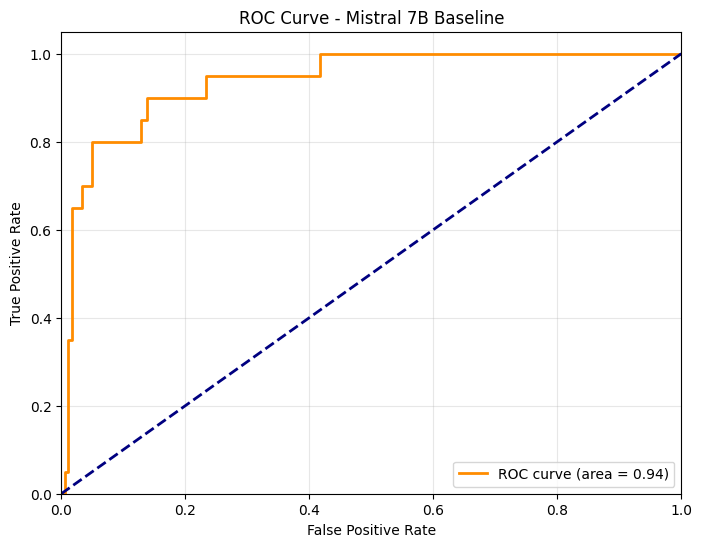

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from tqdm import tqdm
import time

# CONFIGURATION
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.2"
INPUT_FILE = 'llm_baseline_inputs.csv'
OUTPUT_FILE = 'mistral_prob_results.csv'

# 1. LOAD MODEL
print(f"Loading model: {MODEL_ID}...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto"
)

# 2. IDENTIFY TOKEN IDs
# We want to compare the probability of "Yes" (Toxic) vs "No" (Non-Toxic)
yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("No", add_special_tokens=False)[0]

print(f"Token ID for 'Yes': {yes_token_id}")
print(f"Token ID for 'No': {no_token_id}")

# 3. PROBABILITY FUNCTION
def get_toxicity_score(text):
    prompt = f"""[INST] You are the best content moderator in the history.
                        You are very meticulous and pay close attention to
                        the meaning of each word and the overall context of
                        each text because if you don't perform extremely well,
                        you will lose your job and your company will close.
                        Is the following text toxic? Answer with 'Yes' or 'No' only.
                        \nText: \"{text}\"
                        \nAnswer: [/INST]"""

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]

    yes_score = logits[yes_token_id].item()
    no_score = logits[no_token_id].item()

    # Calculate Softmax Probability for "Yes" vs "No"
    prob_toxic = np.exp(yes_score) / (np.exp(yes_score) + np.exp(no_score))

    return prob_toxic

# 4. INFERENCE LOOP
df = pd.read_csv(INPUT_FILE)
print(f"Starting inference on {len(df)} samples...")

toxicity_scores = []
predictions = []
latencies = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['llm_prompt']
    start_time = time.time()

    try:
        prob = get_toxicity_score(text)
    except Exception as e:
        print(f"Error: {e}")
        prob = 0.5 # threshold

    end_time = time.time()
    latency_ms = (end_time - start_time) * 1000
    latencies.append(latency_ms)

    toxicity_scores.append(prob)
    predictions.append(1 if prob >= 0.5 else 0)

df['toxicity_prob'] = toxicity_scores
df['llm_pred'] = predictions
df['latency_ms'] = latencies


df.to_csv(OUTPUT_FILE, index=False)

# 5. METRICS & ROC CURVE
y_true = df['final_label']
y_scores = df['toxicity_prob']

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
avg_latency = sum(latencies) / len(latencies)

print("\n" + "="*40)
print(f"ROC-AUC SCORE: {roc_auc:.4f}")
print(f"F1-SCORE     : {f1_score(y_true, predictions):.4f}")
print(f"AVG LATENCY  : {avg_latency:.4f}")
print("="*40)

# 6. PLOT ROC CURVE
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Mistral 7B Baseline')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [5]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.3 MB/s eta 0:00:00
